In [202]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Training Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

In [7]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

--2022-11-28 23:51:41--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174298785 (166M) [application/zip]
Saving to: ‘BelgiumTSC_Training.zip’

BelgiumTSC_Training 100%[===================>] 166.22M  8.56MB/s    in 20s     

2022-11-28 23:52:02 (8.18 MB/s) - ‘BelgiumTSC_Training.zip’ saved [174298785/174298785]



Test Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

In [8]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

--2022-11-28 23:52:27--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77877833 (74M) [application/zip]
Saving to: ‘BelgiumTSC_Testing.zip’

BelgiumTSC_Testing. 100%[===================>]  74.27M  8.70MB/s    in 9.6s    

2022-11-28 23:52:38 (7.76 MB/s) - ‘BelgiumTSC_Testing.zip’ saved [77877833/77877833]



Traindata & TestData Variables

In [100]:
!rm -rf /content/Testing/00052

In [205]:
import torchvision
test_path = '/content/Testing'
train_path = '/content/Training'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
train_dataLoader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,  num_workers=0)
print('Train',len(train_data))

test_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
print('TEST',len(test_data))
test_dataLoader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,  num_workers=0)


Train 4575
TEST 4575


Hyper Parameters

In [206]:
num_classes = 62
num_epochs = 20
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    model.cuda()

cuda


In [207]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [208]:
import time
start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []
train_loss = []

for epoch in range(num_epochs):
  for i, data in enumerate(train_dataLoader):
    images, labels = data[0].to(device), data[1].to(device)

    #Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backpropogation and Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Train Accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)

    correct = (predicted == labels).sum().item()
    
    steps = i + 1
    accuracy = (correct / total) * 100
    accuracy_list.append(accuracy)
    steps_list.append(steps)
    train_loss.append(loss.item())
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
          accuracy))
    
    

print("######## Training Finished in {} seconds ###########".format(time.time()-start_time))
print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)

Epoch [1/20], Step [1/72], Loss: 6.9078, Accuracy: 0.00%
Epoch [1/20], Step [2/72], Loss: 12.9434, Accuracy: 7.81%
Epoch [1/20], Step [3/72], Loss: 6.7163, Accuracy: 7.81%
Epoch [1/20], Step [4/72], Loss: 6.5120, Accuracy: 1.56%
Epoch [1/20], Step [5/72], Loss: 5.1717, Accuracy: 1.56%
Epoch [1/20], Step [6/72], Loss: 8.7483, Accuracy: 0.00%
Epoch [1/20], Step [7/72], Loss: 5.0781, Accuracy: 10.94%
Epoch [1/20], Step [8/72], Loss: 5.0962, Accuracy: 9.38%
Epoch [1/20], Step [9/72], Loss: 5.1112, Accuracy: 6.25%
Epoch [1/20], Step [10/72], Loss: 4.8605, Accuracy: 4.69%
Epoch [1/20], Step [11/72], Loss: 3.9592, Accuracy: 15.62%
Epoch [1/20], Step [12/72], Loss: 5.8477, Accuracy: 3.12%
Epoch [1/20], Step [13/72], Loss: 4.1704, Accuracy: 9.38%
Epoch [1/20], Step [14/72], Loss: 4.2013, Accuracy: 12.50%
Epoch [1/20], Step [15/72], Loss: 4.3468, Accuracy: 3.12%
Epoch [1/20], Step [16/72], Loss: 4.0848, Accuracy: 6.25%
Epoch [1/20], Step [17/72], Loss: 4.1767, Accuracy: 7.81%
Epoch [1/20], Step 

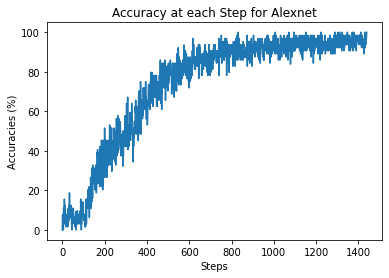

In [209]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

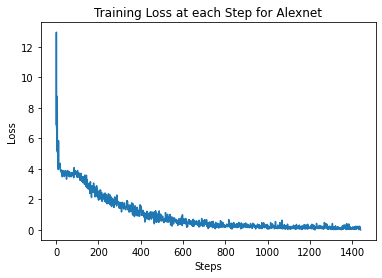

In [210]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [211]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        print('labels:',target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [212]:
for epoch in range(num_epochs):
  evaluate(test_dataLoader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.08533	Accuracy: 97.48634338378906 %

Average Validation loss: 0.09614	Accuracy: 97.0054702758789 %

Average Validation loss: 0.08292	Accuracy: 97.59563446044922 %

Average Validation loss: 0.09193	Accuracy: 97.1584701538086 %

Average Validation loss: 0.09909	Accuracy: 96.7213134765625 %

Average Validation loss: 0.09473	Accuracy: 97.0273208618164 %

Average Validation loss: 0.08947	Accuracy: 97.28961944580078 %

Average Validation loss: 0.08467	Accuracy: 97.46448516845703 %

Average Validation loss: 0.09832	Accuracy: 96.87432098388672 %

Average Validation loss: 0.09143	Accuracy: 97.20218658447266 %

Average Validation loss: 0.09502	Accuracy: 97.22404479980469 %

Average Validation loss: 0.09529	Accuracy: 97.04917907714844 %

Average Validation loss: 0.09125	Accuracy: 97.0273208618164 %

Average Validation loss: 0.09845	Accuracy: 96.89617919921875 %

Average Validation loss: 0.09652	Accuracy: 97.11475372314453 %

Average Validation loss: 0.09127	Accuracy: 9

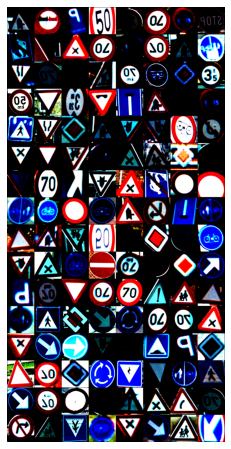

In [199]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [180]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

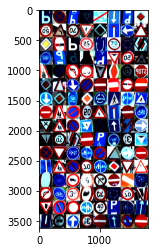

In [200]:
dataiter = iter(train_dataLoader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [73]:
PATH = '/content/BTSD_Alx'
torch.save(model.state_dict(), PATH)